In [1]:
import time
import random
import pandas as pd
import numpy as np
import gc
import re
import torch
from torchtext import data
import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter
from textblob import TextBlob
from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torchtext.data import Example
from sklearn.metrics import f1_score
import torchtext
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

Using TensorFlow backend.


In [2]:
embed_size = 300 # how big is each word vector
max_features = 150000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 6 # how many times to iterate over all samples
n_splits = 4 # Number of K-fold Splits

SEED = 1029

In [3]:
def seed_everything(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")    
    
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)    

In [5]:
from sklearn.preprocessing import StandardScaler


def add_features(df):
    
    df['question_text'] = df['question_text'].apply(lambda x:str(x))
    df['total_length'] = df['question_text'].apply(len)
    df['capitals'] = df['question_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']  

    return df

train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

# lower
# train_df["question_text"] = train_df["question_text"].apply(lambda x: x.lower())
# test_df["question_text"] = test_df["question_text"].apply(lambda x: x.lower())

# Clean the text
train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: clean_text(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))

# Clean numbers
train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_numbers(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_numbers(x))

# Clean speelings
train_df["question_text"] = train_df["question_text"].apply(lambda x: replace_typical_misspell(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: replace_typical_misspell(x))

## fill up the missing values
train_X = train_df["question_text"].fillna("_##_").values
test_X = test_df["question_text"].fillna("_##_").values

###################### Add Features ###############################
# train = add_features(train_df)
# test = add_features(test_df)

# features = train[['caps_vs_length', 'words_vs_unique']].fillna(0)
# test_features = test[['caps_vs_length', 'words_vs_unique']].fillna(0)

# ss = StandardScaler()
# ss.fit(np.vstack((features, test_features)))
# features = ss.transform(features)
# test_features = ss.transform(test_features)
###########################################################################

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [8]:
train_X
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

vocab = build_vocab(train_df["question_text"])
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(train_X[:10]).toarray()
# sns.heatmap(tfidf, annot=True, cbar=False, xticklabels=vocab,
#             yticklabels= ['Sentence 1', 'Sentence 2'])


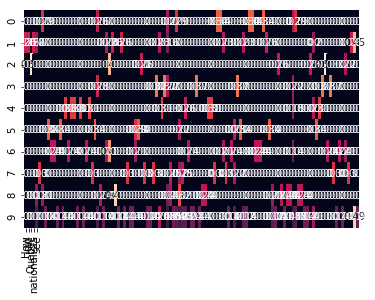

In [9]:
len(vocab)
d1 = dict(list(vocab.items())[:5])
sns.heatmap(tfidf, annot=True, cbar=False, xticklabels=d1)

In [7]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
# train_X = tokenizer.texts_to_sequences(train_X)
# test_X = tokenizer.texts_to_sequences(test_X)

# ## Pad the sentences 
# train_X = pad_sequences(train_X, maxlen=maxlen)
# test_X = pad_sequences(test_X, maxlen=maxlen)

In [259]:
tokenizer.document_count

1306122

In [260]:
wc = tokenizer.word_counts
sorted_by_value = sorted(wc.items(), key=lambda kv: kv[1])
common200 = [w[0] for w in sorted_by_value[::-1][:200]]

In [ ]:
train_in = train_df[train_df["target"]==1]["question_text"]
train_sin = train_df[train_df["target"]==0]["question_text"]
train_in[:20]

In [ ]:
def add_features(df):
    
    df['question_text'] = df['question_text'].progress_apply(lambda x:str(x))
    df['total_length'] = df['question_text'].progress_apply(len)
    df['capitals'] = df['question_text'].progress_apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.progress_apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].progress_apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']  

    return df
add_features(train_df)


In [280]:
train_in = train_df[train_df["target"]==1]
train_sin = train_df[train_df["target"]==0]


print(train_in["caps_vs_length"].mean())
print(train_sin["caps_vs_length"].mean())
print()
print(train_in["words_vs_unique"].mean())
print(train_sin["words_vs_unique"].mean())




0.040119950317498924
0.04327927181366581

0.9312884504191719
0.956951707548512


In [190]:
tokenizer_in = Tokenizer(num_words=max_features)
tokenizer_in.fit_on_texts(list(train_in))

tokenizer_sin = Tokenizer(num_words=max_features)
tokenizer_sin.fit_on_texts(list(train_sin))

In [ ]:
wc1 = tokenizer_in.word_counts
sorted_by_value_in = sorted(wc1.items(), key=lambda kv: kv[1])


wc1 = tokenizer_sin.word_counts
sorted_by_value_sin = sorted(wc1.items(), key=lambda kv: kv[1])
ws_sin = [w[0] for w in sorted_by_value_sin[::-1][:88000]]


ws_in = [w[0] for w in sorted_by_value_in[::-1] if w[0] not in ws_sin and len(w[0])>4]


ws_in = ws_in[:1000]

# ws = [w for w in sorted_by_value1[::-1][0:500] if w[0] not in common200 and len(w[0])>2][:200]
# ws = [w[0] for w in ws]
# wc2 = tokenizer_sin.word_counts
# sorted_by_value1 = sorted(wc1.items(), key=lambda kv: kv[1])
# ws = [w for w in sorted_by_value1[::-1][0:500] if w[0] not in common200 and len(w[0])>2][:200]
# ws = [w[0] for w in ws§]


ws_in

In [159]:
badwords = '4r5e 5h1t 5hit a55 anal anus ar5e arrse arse ass ass-fucker asses assfucker assfukka asshole assholes asswhole a_s_s b!tch b00bs b17ch b1tch ballbag balls ballsack bastard beastial beastiality bellend bestial bestiality bi+ch biatch bitch bitcher bitchers bitches bitchin bitching bloody blow job blowjob blowjobs boiolas bollock bollok boner boob boobs booobs boooobs booooobs booooooobs breasts buceta bugger bum bunny fucker butt butthole buttmuch buttplug c0ck c0cksucker carpet muncher cawk chink cipa cl1t clit clitoris clits cnut cock cock-sucker cockface cockhead cockmunch cockmuncher cocks cocksuck cocksucked cocksucker cocksucking cocksucks cocksuka cocksukka cok cokmuncher coksucka coon cox crap cum cummer cumming cums cumshot cunilingus cunillingus cunnilingus cunt cuntlick cuntlicker cuntlicking cunts cyalis cyberfuc cyberfuck cyberfucked cyberfucker cyberfuckers cyberfucking d1ck damn dick dickhead dildo dildos dink dinks dirsa dlck dog-fucker doggin dogging donkeyribber doosh duche dyke ejaculate ejaculated ejaculates ejaculating ejaculatings ejaculation ejakulate fuckfucker f4nny fag fagging faggitt faggot faggs fagot fagots fags fanny fannyflaps fannyfucker fanyy fatass fcuk fcuker fcuking feck fecker felching fellate fellatio fingerfuck fingerfucked fingerfucker fingerfuckers fingerfucking fingerfucks fistfuck fistfucked fistfucker fistfuckers fistfucking fistfuckings fistfucks flange fook fooker fuck fucka fucked fucker fuckers fuckhead fuckheads fuckin fucking fuckings fuckingshitmotherfucker fuckme fucks fuckwhit fuckwit fudge packer fudgepacker fuk fuker fukker fukkin fuks fukwhit fukwit fux fux0r f_u_c_k gangbang gangbanged gangbangs gaylord gaysex goatse God god-dam god-damned goddamn goddamned hardcoresex hell heshe hoar hoare hoer homo hore horniest horny hotsex jack-off jackoff jap jerk-off jism jiz jizm jizz kawk knob knobead knobed knobend knobhead knobjocky knobjokey kock kondum kondums kum kummer kumming kums kunilingus l3i+ch l3itch labia lmfao lust lusting m0f0 m0fo m45terbate ma5terb8 ma5terbate masochist master-bate masterb8 masterbat* masterbat3 masterbate masterbation masterbations masturbate mo-fo mof0 mofo mothafuck mothafucka mothafuckas mothafuckaz mothafucked mothafucker mothafuckers mothafuckin mothafucking mothafuckings mothafucks mother fucker motherfuck motherfucked motherfucker motherfuckers motherfuckin motherfucking motherfuckings motherfuckka motherfucks muff mutha muthafecker muthafuckker muther mutherfucker n1gga n1gger nazi nigg3r nigg4h nigga niggah niggas niggaz nigger niggers nob nob jokey nobhead nobjocky nobjokey numbnuts nutsack orgasim orgasims orgasm orgasms p0rn pawn pecker penis penisfucker phonesex phuck phuk phuked phuking phukked phukking phuks phuq pigfucker pimpis piss pissed pisser pissers pisses pissflaps pissin pissing pissoff poop porn porno pornography pornos prick pricks pron pube pusse pussi pussies pussy pussys rectum retard rimjaw rimming s hit s.o.b. sadist schlong screwing scroat scrote scrotum semen sex sh!+ sh!t sh1t shag shagger shaggin shagging shemale shi+ shit shitdick shite shited shitey shitfuck shitfull shithead shiting shitings shits shitted shitter shitters shitting shittings shitty skank slut sluts smegma smut snatch son-of-a-bitch spac spunk s_h_i_t t1tt1e5 t1tties teets teez testical testicle tit titfuck tits titt tittie5 tittiefucker titties tittyfuck tittywank titwank tosser turd tw4t twat twathead twatty twunt twunter v14gra v1gra vagina viagra vulva w00se wang wank wanker wanky whoar whore willies willy xrated xxx'

In [ ]:
listb = badwords.split()
[w for w in wc1.items() if w[0] in listb and len(w[0])>1]

In [248]:
def search(q):
    words = q.split()
    s = 0
    for w in words:
        if w in listb:
            return q
        else:
            return None
    
len(train_in.apply(lambda x : search(x)).dropna())

40

In [249]:
t = train_sin.apply(lambda x : search(x)).dropna()
len(t)

58

In [246]:
pd.set_option('display.max_colwidth', -1)
t

737125     jainis don ' t .  eat root vegetables .  can they not even use root vegetables for other purpose like keeping a slice of garlic under shocks to cure cough ? 
857182     horlaxen :  improve your stamina ?                                                                                                                           
1129737    proportionately ,   ( and vaguely )  ,  speaking ,  how have suicide rates fluctuated throughout history ?                                                   
Name: question_text, dtype: object

In [216]:
train_n = train_df["question_text"]
len(train_n.apply(lambda x : search(x)).dropna())/len(train_n)

0.0001447031747417163

In [217]:
test_n = test_df["question_text"]
len(test_n.apply(lambda x : search(x)).dropna())/len(test_n)

0.00014191946070604933